In [17]:
import os
import warnings

import nltk
import re
import random
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
from nltk.corpus import stopwords

SEED = 777
random.seed(SEED)
np.random.seed(SEED)

warnings.filterwarnings("ignore")

In [ ]:
# nltk.download('stopwords') 
# nltk.download('punkt') 

In [20]:
config = yaml_read('config.yaml')
config

{'dataset': './dataset.csv',
 'model': {'max_seq_len': 75, 'n_label': 13, 'walk_len': 10}}

In [19]:
data_dir = config['dataset']
df = pd.read_csv(data_dir)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [48]:
sentiment_lb = df.sentiment.value_counts().index.to_list()
sentiment_dict = {value: idx for idx, value in enumerate(sentiment_lb)}

def remove_stopwords(text, stopwords=stopwords.words("english")): 
    tokens = nltk.word_tokenize(text)
    tokens = [w.lower().strip() for w in tokens if not w.lower() in stopwords]
    return tokens

def clean_content(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)     # remove urls
    text = re.sub(r'\@\w+|\#', '', text)                                        # remove at and hash tags
    text = text.encode('ascii', 'ignore').decode('ascii')                       # remove emojis
    text = re.sub(r'\s+', ' ', text).strip()                                    # remove extra spaces
    tokenized_text = remove_stopwords(text)                                     # remove stopwords
    return tokenized_text 

def process_label(sentiment, sentiment_dict=sentiment_dict): 
    label = sentiment_dict[sentiment]
    return label

# EDA

In [4]:
df.sentiment.value_counts()

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

Text(0, 0.5, 'Proportion of each sentimental types')

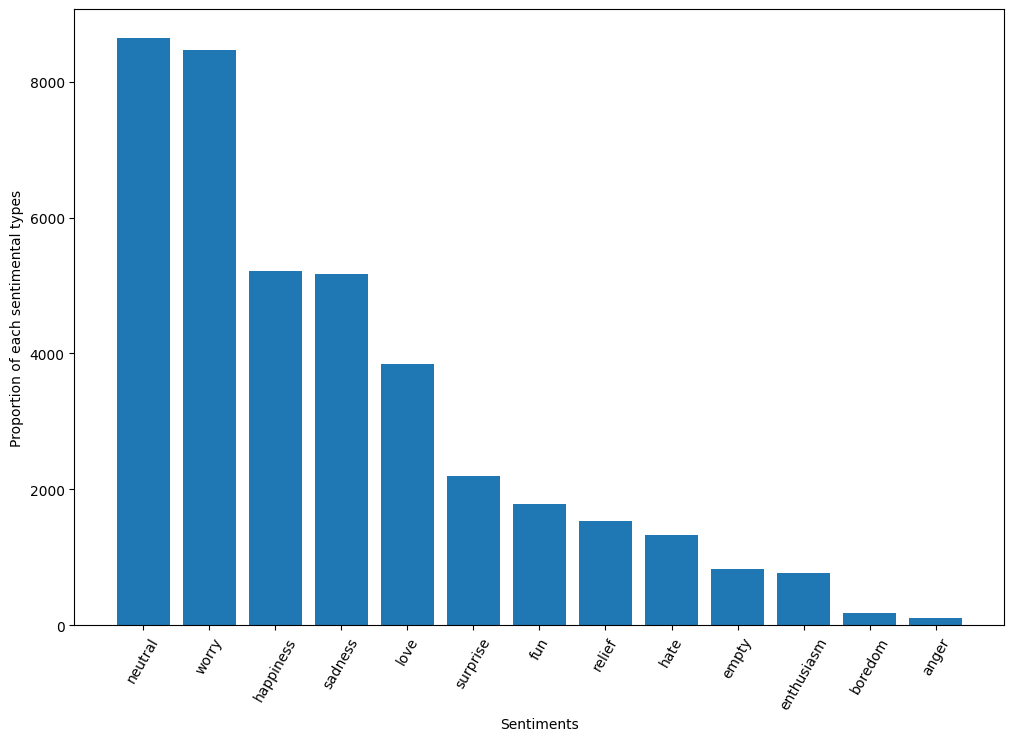

In [36]:
sentiment_lb = df.sentiment.value_counts().index.to_list()
sentiment_vl = df.sentiment.value_counts().to_list()

plt.figure(figsize=(12, 8))
plt.bar(range(len(sentiment_vl)), sentiment_vl)
plt.xticks(range(len(sentiment_vl)), sentiment_lb, rotation=60)
plt.xlabel('Sentiments')
plt.ylabel('Proportion of each sentimental types')

In [44]:
# Proportion of word-length
content = df.content
content = content.apply(lambda x: clean_content(x))

word_len_prop = {}

for row in tqdm(content, desc='In Progress...'): 
    word_len = len(row)
    try: 
        word_len_prop[word_len] += 1
    except: 
        word_len_prop[word_len] = 1

In Progress...: 100%|██████████| 40000/40000 [00:00<00:00, 1538855.30it/s]


Text(0, 0.5, "Number of comment's length")

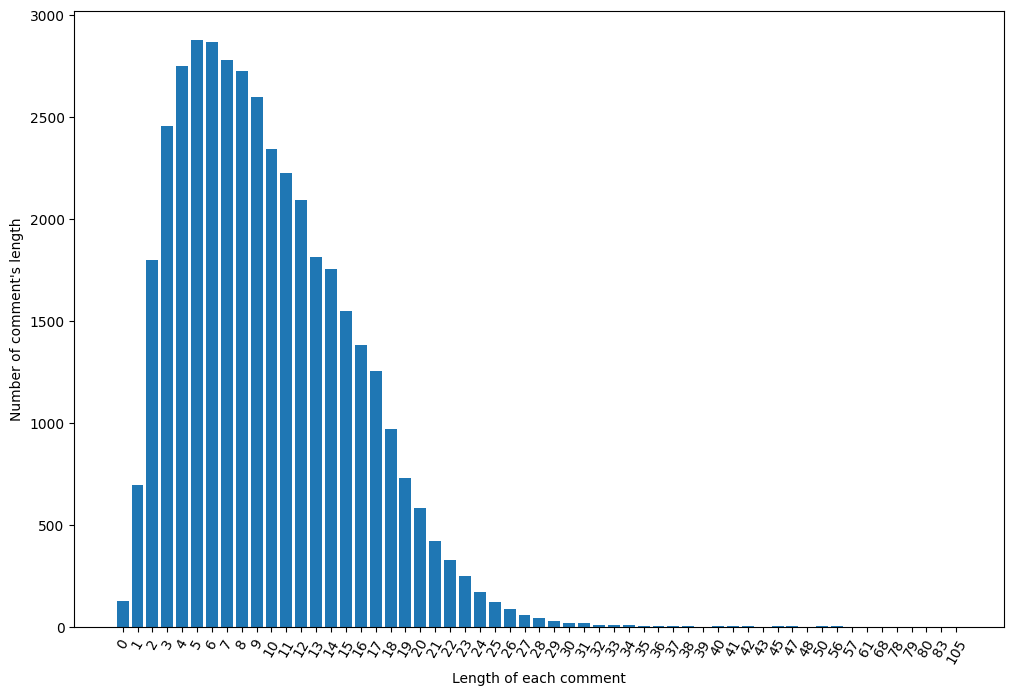

In [47]:
sorted_word_dict = dict(sorted(word_len_prop.items(), key=lambda x: x[0]))
plt.figure(figsize=(12, 8))
plt.bar(range(len(sorted_word_dict.values())), sorted_word_dict.values())
plt.xticks(range(len(sorted_word_dict.values())),sorted_word_dict.keys(), rotation=60)
plt.xlabel('Length of each comment')
plt.ylabel('Number of comment\'s length')

In [40]:
# Word-length per group
sentiment_lb = df.sentiment.value_counts().index.to_list()


dict_keys(['a', 'b'])

# Dataset

In [56]:
content = df.content

In [75]:
label = df.sentiment
label = label.apply(lambda x: process_label(x))
label

0         9
1         3
2         3
3        10
4         0
         ..
39995     0
39996     4
39997     4
39998     2
39999     4
Name: sentiment, Length: 40000, dtype: int64

In [61]:
content = content.apply(lambda x: clean_tweet(x))
content

0        i know i was listenin to bad habit earlier and...
1        layin n bed with a headache ughhhh...waitin on...
2                      funeral ceremony...gloomy friday...
3                     wants to hang out with friends soon!
4        we want to trade with someone who has houston ...
                               ...                        
39995                                                     
39996                        happy mothers day all my love
39997    happy mother's day to all the mommies out ther...
39998    wassup beautiful!!! follow me!! peep out my ne...
39999    bullet train from tokyo the gf and i have been...
Name: content, Length: 40000, dtype: object

In [78]:
sample = content[: 10]

In [79]:
model = Word2Vec(sample,
                sg=1, # Skip-gram
                vector_size=10,
                min_count=0,
                window=2,
                workers=2,
                seed=0)

In [80]:
model.wv.vectors.shape

(35, 10)